# LOAD package

In [1]:
%pylab
from astropy.table import Table

Using matplotlib backend: agg
Populating the interactive namespace from numpy and matplotlib


In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.interpolate import interp1d
from scipy.integrate import quad,trapz
from scipy.special import gamma
from scipy.optimize import curve_fit

In [3]:
import seaborn as sns
sns.set()
# sns.set(rc={'figure.figsize':(15.7,9.27)})
# sns.set_style("ticks")

# Load data

## Load total nwp

### 直接观测结果

In [38]:
cen_bin = [11.4, 11.6, 11.8]
sate_bin = [9.0, 9.5, 10.0, 10.5,11.0]
rvir = np.array([693.897315144089,847.9688670260847])/1000

In [39]:
r = np.logspace(-2, 2, 21)
r = r[4:]
r_need = 10**((np.log10(r[1:])+np.log10(r[:-1]))/2.0)
# r_need = r_need[4:-2]
number = np.zeros((2,4))

for i in range(len(cen_bin)-1):
    for j in range(len(sate_bin)-1):
        data = np.load("/home/yunzheng/PAC/code/PAC/0.5_0.7/CMASS_PAC/%.1f_%.1f.npy"%(cen_bin[i],sate_bin[j]),allow_pickle=True)
        index = np.searchsorted(r,rvir[i])-1
        
        nwp_new = data[1][1:index+1]
        rp_new = np.hstack((r[1:index+1],rvir[i]))
        r_need_new = r_need[1:index+1]
#         print(r_need_new)
        
    
        r_inter = (rp_new[-1] + rp_new[-2])/ 2.0
        print("The inter r:")
        print(r_inter)
        r_need_inter = np.array([r_need_new[-2],r_need_new[-1]])
        print("the inter rbin:")
        print(r_need_inter)
        nwp_inter = np.array([nwp_new[-2],nwp_new[-1]])
        print("the nwp interbin:")
        print(nwp_inter)

        f = interp1d(r_need_inter,nwp_inter,fill_value ='extrapolate')
        nwp_inter0 = f(r_inter)
        nwp_new = np.hstack((nwp_new[:-1],nwp_inter0))
        print("The nwp_new:")
        print(nwp_inter0)

        
        
        print("the nwp_new:")
        print(nwp_new)
        N = np.zeros(len(rp_new)-1)
        print("The number for each bin:")
        for k in range(len(rp_new)-1):
            N[k] = np.pi * (rp_new[k+1]**2-rp_new[k]**2) * nwp_new[k]
            print(N[k])
        print("The total number:")
        print(np.sum(N)) 
        number[i][j] = np.sum(N)
        
np.save("./all/original_num.npy",number)

The inter r:
0.6624273298121413
the inter rbin:
[0.50118723 0.79432823]
the nwp interbin:
[1.16774879 0.93350439]
The nwp_new:
1.0389043421013269
the nwp_new:
[6.31984231 4.21203406 2.8987441  1.16774879 1.03890434]
The number for each bin:
0.3001755289259323
0.502528754442017
0.8687182002318232
0.8790598953037547
0.2721574378753517
The total number:
2.8226398167788784
The inter r:
0.6624273298121413
the inter rbin:
[0.50118723 0.79432823]
the nwp interbin:
[1.33963319 0.76625287]
The nwp_new:
1.0242494739965178
the nwp_new:
[8.14564558 4.72264934 2.77026232 1.33963319 1.02424947]
The number for each bin:
0.38689627800863097
0.5634491678292581
0.8302137792712161
1.0084513236590178
0.2683183631942902
The total number:
3.0573289119624127
The inter r:
0.6624273298121413
the inter rbin:
[0.50118723 0.79432823]
the nwp interbin:
[1.1412573  0.72795841]
The nwp_new:
0.9139252203786153
the nwp_new:
[6.44338695 3.90440282 2.41139456 1.1412573  0.91392522]
The number for each bin:
0.30604356728

In [40]:
number

array([[2.82263982, 3.05732891, 2.59306976, 1.69881549],
       [4.39441477, 4.83977684, 4.1488538 , 3.06461979]])

### 计算修正比例

In [41]:
r0 = np.logspace(-2, 2, 21)
# r = r[4:-2]
r_need0 = 10**((np.log10(r0[1:])+np.log10(r0[:-1]))/2.0)

number_new = np.zeros((2,4))
for i in range(len(cen_bin)-1):
    for j in range(len(sate_bin)-1):
        nwp = np.load("/home/yunzheng/PAC/code/PAC/0.5_0.7/CMASS_PAC/%.1f_%.1f.npy"%(cen_bin[i],sate_bin[j]),allow_pickle=True)


 
        def func_wp(rp,r1,gam):
            y = rp**(1-gam)*r1**gam*gamma(0.5)*gamma(0.5*(gam-1))/gamma(0.5*gam)
            return y
        

        popt,pcov = curve_fit(func_wp,nwp[0][1:7],nwp[1][1:7],sigma = nwp[2][1:7],p0=(5,2.05))
        print(popt)
        perr = np.sqrt(np.diag(pcov))
        print(perr)
        

        def part_wp1(r,rp0,r1,gam):
            y = 2*r1**gam*r**(1-gam)*(r**2 - rp0**2)**(-0.5)
            return y

        def func_wp1(rp0,rvir0,r1,gam):
            y = quad(part_wp1,rp0,rvir0,args = (rp0,popt[0],popt[1]))
            return y
        
        
       #################用函数去拟合得到100kpc以内的值#####################
        nwp_new = func_wp(r0[:5],*popt)
        index = np.searchsorted(r0,rvir[i])-1
        
#         print("The length of index in Rvir :")
#         print(index)


        nwp_new = np.hstack((nwp_new,nwp[1][1:index+1-4]))
        rp_new = np.hstack((r0[:index+1],rvir[i]))
        r_need_new = r_need0[:index+1]
        print("The length of nwp:")
        print(len(nwp_new))
        print("The length of rp:")
        print(len(rp_new))
        
        r_inter = (rp_new[-1] + rp_new[-2])/ 2.0
        print("The inter r:")
        print(r_inter)
        r_need_inter = np.array([r_need_new[-2],r_need_new[-1]])
        print("the inter rbin:")
        print(r_need_inter)
        nwp_inter = np.array([nwp_new[-2],nwp_new[-1]])
        print("the nwp interbin:")
        print(nwp_inter)

        f = interp1d(r_need_inter,nwp_inter,fill_value ='extrapolate')
        nwp_inter0 = f(r_inter)
        nwp_new = np.hstack((nwp_new[:-1],nwp_inter0))
        print("The nwp_new:")
        print(nwp_inter0)

    
        print("the nwp_new:")
        print(nwp_new)
        N = np.zeros(len(rp_new)-1)
        for k in range(len(rp_new)-1):
            ratio_corr = (func_wp1(rp_new[k],rvir[i],popt[0],popt[1])[0])/func_wp(rp_new[k],*popt)
#             print(ratio_corr)
            N[k] = np.pi * (rp_new[k+1]**2-rp_new[k]**2) * nwp_new[k] * ratio_corr
            print("The inter number")
            print(N[k])
        print("The total number:")
        print(np.sum(N)) 
        number_new[i][j] = np.sum(N)


np.save("./all/corr_num.npy",number_new)

[0.50111976 2.08650805]
[0.01420521 0.09419287]
The length of nwp:
10
The length of rp:
11
The inter r:
0.6624273298121413
the inter rbin:
[0.50118723 0.79432823]
the nwp interbin:
[1.16774879 0.93350439]
The nwp_new:
1.0389043421013269
the nwp_new:
[104.54601055  63.38782578  38.4329965   23.30250646  14.12866175
   6.31984231   4.21203406   2.8987441    1.16774879   1.03890434]
The inter number
0.04934890678839896
The inter number
0.07485385875337346
The inter number
0.11323754729012064
The inter number
0.17053859755045794
The inter number
0.2548943836083135
The inter number
0.27739665081322534
The inter number
0.4392750188149805
The inter number
0.6856654871655302
The inter number
0.5603538636881337
The inter number
0.07851986202320284
The total number:
2.704084176495737
[0.51924783 2.2525153 ]
[0.00584271 0.03595358]
The length of nwp:
10
The length of rp:
11
The inter r:
0.6624273298121413
the inter rbin:
[0.50118723 0.79432823]
the nwp interbin:
[1.33963319 0.76625287]
The nwp_ne

In [43]:
num0 = np.load("./all/original_num.npy")
num1 = np.load("./all/corr_num.npy")
fq_original = num1/num0

In [44]:
fq_original

array([[0.95799831, 1.1011878 , 1.04617222, 0.95184658],
       [0.96655901, 1.00467757, 1.02488156, 0.90544457]])

## Load each field nwp

In [45]:
m_sate = [9.0,9.5,10.0,10.5,11.0]
#m_sate = np.linspace(9.0,11.7,28)
r = np.logspace(-2, 2, 21)
r = r[4:]
r_need = 10**((np.log10(r[1:])+np.log10(r[:-1]))/2.0)
#m_sate = [9.5,10.0]
m_cen = [11.4,11.6,11.8]
#n = ['blue','red']
jack=50
zs = ['0p55','0p65']


num0 = np.load("./all/original_num.npy")
num1 = np.load("./all/corr_num.npy")
fq_original = num1/num0

number = np.zeros((2,4,50))
for i in range(len(m_cen)-1):
    for j in range(len(m_sate)-1):

        pcf = np.zeros((jack,len(r_need)))
        for k in range(len(zs)):
            data = np.load('/home/yunzheng/PAC/code/PAC/0.5_0.7/CMASS_PAC/%s_%.1f_%.1f_results_jack.npy' % (zs[k],m_cen[i],m_sate[j]))
            pcf+=data

        pcf = pcf/len(zs)
        
        for q in range(50):
            
            index = np.searchsorted(r,rvir[i])-1
            print("The index rvir:")
            print(index)
            print(r[index])

            nwp_new = pcf[q][1:index+1]
            rp_new = np.hstack((r[1:index+1],rvir[i]))
            r_need_new = r_need[1:index+1]
            
            
            r_inter = (rp_new[-1] + rp_new[-2]) / 2.0
            print("The inter r:")
            print(r_inter)
            
            r_need_inter = np.array([r_need_new[-2],r_need_new[-1]])
            print("the inter rbin:")
            print(r_need_inter)
            nwp_inter = np.array([nwp_new[-2],nwp_new[-1]])
            print("the nwp interbin:")
            print(nwp_inter)
            
            
            f = interp1d(r_need_inter,nwp_inter,fill_value ='extrapolate')
            nwp_inter0 = f(r_inter)
            nwp_new = np.hstack((nwp_new[:-1],nwp_inter0))
            print("The nwp_new:")
            print(nwp_new)
            
            
            N = np.empty(len(rp_new) - 1)
            for p in range(len(rp_new) - 1):
                print("The frac:")
                print(fq_original[i][j])
                N[p] = np.pi * (rp_new[p+1]**2-rp_new[p]**2) * nwp_new[p] * fq_original[i][j]
                
                
            print("The total number:")
            print(np.sum(N))
            
            number[i][j][q] = np.sum(N)
            

np.save("./all/eachfield_result.npy",number)
            


The index rvir:
5
0.6309573444801934
The inter r:
0.6624273298121413
the inter rbin:
[0.50118723 0.79432823]
the nwp interbin:
[1.15013201 0.93457642]
The nwp_new:
[6.24659025 4.18823566 2.94289417 1.15013201 1.03156721]
The frac:
0.9579983108087684
The frac:
0.9579983108087684
The frac:
0.9579983108087684
The frac:
0.9579983108087684
The frac:
0.9579983108087684
The total number:
2.696160532759002
The index rvir:
5
0.6309573444801934
The inter r:
0.6624273298121413
the inter rbin:
[0.50118723 0.79432823]
the nwp interbin:
[1.22688891 0.99135823]
The nwp_new:
[6.46821784 4.34034338 2.98416127 1.22688891 1.09733696]
The frac:
0.9579983108087684
The frac:
0.9579983108087684
The frac:
0.9579983108087684
The frac:
0.9579983108087684
The frac:
0.9579983108087684
The total number:
2.8073383629284336
The index rvir:
5
0.6309573444801934
The inter r:
0.6624273298121413
the inter rbin:
[0.50118723 0.79432823]
the nwp interbin:
[1.20566074 0.96096085]
The nwp_new:
[6.45491276 4.33317784 2.952466

In [34]:
number

array([[[3.04131341, 3.1226216 , 3.1324651 , 3.22078186, 3.15340048,
         3.05669255, 2.98386713, 2.93951199, 2.90514913, 3.07198651,
         2.94341832, 3.04430308, 3.04778177, 3.02479271, 3.0271125 ,
         3.14039144, 3.14631129, 3.04351829, 3.17019858, 3.09991387,
         3.16062075, 3.15577703, 3.06063077, 3.03328241, 3.10338952,
         3.15954884, 2.98062541, 3.09671089, 3.12027883, 3.04078271,
         3.14137526, 3.0678032 , 3.10900068, 3.02747906, 3.06860692,
         3.13366895, 3.04320411, 3.09101489, 3.11563568, 3.0870452 ,
         3.1913347 , 3.15395956, 3.15746374, 3.12143516, 3.00294468,
         3.05891553, 3.00437269, 3.15532198, 3.165382  , 3.14266117],
        [3.77136527, 3.74815024, 3.78815887, 3.78691733, 3.75948086,
         3.75571296, 3.71494005, 3.73363167, 3.70355963, 3.68582109,
         3.68642376, 3.64281869, 3.70528622, 3.73495502, 3.78170707,
         3.73027701, 3.76682599, 3.72926204, 3.78169038, 3.77597946,
         3.74509617, 3.72756631, 

In [46]:
number.shape

(2, 4, 50)

In [15]:
pcf[2]

array([8.52624117, 5.38779211, 3.53843609, 2.17624818, 1.16599239,
       0.80102843, 0.45471584, 0.32488059, 0.24630445, 0.16484957,
       0.13410646, 0.10074171, 0.07702177, 0.05424212, 0.03821488,
       0.02549705])

# red galaxy

## all red galaxy

In [47]:
r = np.logspace(-2, 2, 21)
r = r[4:]
r_need = 10**((np.log10(r[1:])+np.log10(r[:-1]))/2.0)
# r_need = r_need[4:-2]
number = np.zeros((2,4))

for i in range(len(cen_bin)-1):
    for j in range(len(sate_bin)-1):
        data = np.load("/home/yunzheng/PAC/code/PAC/0.5_0.7/color_cut_red/%.1f_%.1f.npy"%(cen_bin[i],sate_bin[j]),allow_pickle=True)
        index = np.searchsorted(r,rvir[i])-1
        
        nwp_new = data[1][1:index+1]
        rp_new = np.hstack((r[1:index+1],rvir[i]))
        r_need_new = r_need[1:index+1]
#         print(r_need_new)
        
    
        r_inter = (rp_new[-1] + rp_new[-2])/ 2.0
        print("The inter r:")
        print(r_inter)
        r_need_inter = np.array([r_need_new[-2],r_need_new[-1]])
        print("the inter rbin:")
        print(r_need_inter)
        nwp_inter = np.array([nwp_new[-2],nwp_new[-1]])
        print("the nwp interbin:")
        print(nwp_inter)

        f = interp1d(r_need_inter,nwp_inter,fill_value ='extrapolate')
        nwp_inter0 = f(r_inter)
        nwp_new = np.hstack((nwp_new[:-1],nwp_inter0))
        print("The nwp_new:")
        print(nwp_inter0)

        
        
        print("the nwp_new:")
        print(nwp_new)
        N = np.zeros(len(rp_new)-1)
        print("The number for each bin:")
        for k in range(len(rp_new)-1):
            N[k] = np.pi * (rp_new[k+1]**2-rp_new[k]**2) * nwp_new[k]
            print(N[k])
        print("The total number:")
        print(np.sum(N)) 
        number[i][j] = np.sum(N)
        
np.save("./red_galaxy/original_num.npy",number)

The inter r:
0.6624273298121413
the inter rbin:
[0.50118723 0.79432823]
the nwp interbin:
[0.53459371 0.33143595]
The nwp_new:
0.42284824656944264
the nwp_new:
[4.05191261 2.27757866 1.20444563 0.53459371 0.42284825]
The number for each bin:
0.19245496152915056
0.2717330272534902
0.3609576444590261
0.4024323522707019
0.110771791716316
The total number:
1.3383497772286848
The inter r:
0.6624273298121413
the inter rbin:
[0.50118723 0.79432823]
the nwp interbin:
[0.81120706 0.40506995]
The nwp_new:
0.5878142675886776
the nwp_new:
[5.82122562 2.99825308 1.50823494 0.81120706 0.58781427]
The number for each bin:
0.2764925758653508
0.35771514774241986
0.45199958734570556
0.6106618115966906
0.15398725227188226
The total number:
1.8508563748220492
The inter r:
0.6624273298121413
the inter rbin:
[0.50118723 0.79432823]
the nwp interbin:
[0.97892569 0.47134123]
The nwp_new:
0.6997325111690987
the nwp_new:
[5.47224863 3.05732605 1.89471077 0.97892569 0.69973251]
The number for each bin:
0.2599171

In [48]:
number

array([[1.33834978, 1.85085637, 2.11272513, 1.54282614],
       [1.94185299, 2.86567704, 3.20304631, 2.75032823]])

## 修正比例

In [49]:
r0 = np.logspace(-2, 2, 21)
# r = r[4:-2]
r_need0 = 10**((np.log10(r0[1:])+np.log10(r0[:-1]))/2.0)

number_new = np.zeros((2,4))
for i in range(len(cen_bin)-1):
    for j in range(len(sate_bin)-1):
        nwp = np.load("/home/yunzheng/PAC/code/PAC/0.5_0.7/color_cut_red/%.1f_%.1f.npy"%(cen_bin[i],sate_bin[j]),allow_pickle=True)


 
        def func_wp(rp,r1,gam):
            y = rp**(1-gam)*r1**gam*gamma(0.5)*gamma(0.5*(gam-1))/gamma(0.5*gam)
            return y
        

        popt,pcov = curve_fit(func_wp,nwp[0][1:7],nwp[1][1:7],sigma = nwp[2][1:7],p0=(5,2.05))
        print(popt)
        perr = np.sqrt(np.diag(pcov))
        print(perr)
        

        def part_wp1(r,rp0,r1,gam):
            y = 2*r1**gam*r**(1-gam)*(r**2 - rp0**2)**(-0.5)
            return y

        def func_wp1(rp0,rvir0,r1,gam):
            y = quad(part_wp1,rp0,rvir0,args = (rp0,popt[0],popt[1]))
            return y
        
        
       #################用函数去拟合得到100kpc以内的值#####################
        nwp_new = func_wp(r0[:5],*popt)
        index = np.searchsorted(r0,rvir[i])-1
        
#         print("The length of index in Rvir :")
#         print(index)


        nwp_new = np.hstack((nwp_new,nwp[1][1:index+1-4]))
        rp_new = np.hstack((r0[:index+1],rvir[i]))
        r_need_new = r_need0[:index+1]
        print("The length of nwp:")
        print(len(nwp_new))
        print("The length of rp:")
        print(len(rp_new))
        
        r_inter = (rp_new[-1] + rp_new[-2])/ 2.0
        print("The inter r:")
        print(r_inter)
        r_need_inter = np.array([r_need_new[-2],r_need_new[-1]])
        print("the inter rbin:")
        print(r_need_inter)
        nwp_inter = np.array([nwp_new[-2],nwp_new[-1]])
        print("the nwp interbin:")
        print(nwp_inter)

        f = interp1d(r_need_inter,nwp_inter,fill_value ='extrapolate')
        nwp_inter0 = f(r_inter)
        nwp_new = np.hstack((nwp_new[:-1],nwp_inter0))
        print("The nwp_new:")
        print(nwp_inter0)

    
        print("the nwp_new:")
        print(nwp_new)
        N = np.zeros(len(rp_new)-1)
        for k in range(len(rp_new)-1):
            ratio_corr = (func_wp1(rp_new[k],rvir[i],popt[0],popt[1])[0])/func_wp(rp_new[k],*popt)
#             print(ratio_corr)
            N[k] = np.pi * (rp_new[k+1]**2-rp_new[k]**2) * nwp_new[k] * ratio_corr
            print("The inter number")
            print(N[k])
        print("The total number:")
        print(np.sum(N)) 
        number_new[i][j] = np.sum(N)


np.save("./red_galaxy/corr_num.npy",number_new)

[0.36833974 2.40665728]
[0.00419059 0.04580528]
The length of nwp:
10
The length of rp:
11
The inter r:
0.6624273298121413
the inter rbin:
[0.50118723 0.79432823]
the nwp interbin:
[0.53459371 0.33143595]
The nwp_new:
0.42284824656944264
the nwp_new:
[146.90179306  76.85916113  40.21278792  21.03936979  11.00781875
   4.05191261   2.27757866   1.20444563   0.53459371   0.42284825]
The inter number
0.06967233842728371
The inter number
0.09144262233088056
The inter number
0.11986867311675495
The inter number
0.15676185106971988
The inter number
0.20407696081599208
The inter number
0.18524339087644207
The inter number
0.2521414942495152
The inter number
0.31033945191527584
The inter number
0.2890746494635376
The inter number
0.03758611623877935
The total number:
1.7162075485041814
[0.41754178 2.45260694]
[0.00169263 0.01519821]
The length of nwp:
10
The length of rp:
11
The inter r:
0.6624273298121413
the inter rbin:
[0.50118723 0.79432823]
the nwp interbin:
[0.81120706 0.40506995]
The nw

In [50]:
number_new

array([[1.71620755, 2.44921149, 2.33145305, 1.48966577],
       [2.48384539, 3.56088814, 3.56246844, 2.52407253]])

## Load each field

In [51]:
m_sate = [9.0,9.5,10.0,10.5,11.0]
#m_sate = np.linspace(9.0,11.7,28)
r = np.logspace(-2, 2, 21)
r = r[4:]
r_need = 10**((np.log10(r[1:])+np.log10(r[:-1]))/2.0)
#m_sate = [9.5,10.0]
m_cen = [11.4,11.6,11.8]
#n = ['blue','red']
jack=50
zs = ['0p55','0p65']

num0 = np.load("./red_galaxy/original_num.npy")
num1 = np.load("./red_galaxy/corr_num.npy")
fq_original = num1/num0
print(fq_original)

number = np.zeros((2,4,50))
for i in range(len(m_cen)-1):
    for j in range(len(m_sate)-1):

        pcf = np.zeros((jack,len(r_need)))
        for k in range(len(zs)):
            data = np.load('/home/yunzheng/PAC/code/PAC/0.5_0.7/color_cut_red/%s_%.1f_%.1f_results_jack.npy' % (zs[k],m_cen[i],m_sate[j]))
            pcf+=data

        pcf = pcf/len(zs)
        
        for q in range(50):
            
            index = np.searchsorted(r,rvir[i])-1
            print("The index rvir:")
            print(index)
            print(r[index])

            nwp_new = pcf[q][1:index+1]
            rp_new = np.hstack((r[1:index+1],rvir[i]))
            r_need_new = r_need[1:index+1]
            
            
            r_inter = (rp_new[-1] + rp_new[-2]) / 2.0
            print("The inter r:")
            print(r_inter)
            
            r_need_inter = np.array([r_need_new[-2],r_need_new[-1]])
            print("the inter rbin:")
            print(r_need_inter)
            nwp_inter = np.array([nwp_new[-2],nwp_new[-1]])
            print("the nwp interbin:")
            print(nwp_inter)
            
            
            f = interp1d(r_need_inter,nwp_inter,fill_value ='extrapolate')
            nwp_inter0 = f(r_inter)
            nwp_new = np.hstack((nwp_new[:-1],nwp_inter0))
            print("The nwp_new:")
            print(nwp_new)
            
            
            N = np.empty(len(rp_new) - 1)
            for p in range(len(rp_new) - 1):
                print("The frac:")
                print(fq_original[i][j])
                N[p] = np.pi * (rp_new[p+1]**2-rp_new[p]**2) * nwp_new[p] * fq_original[i][j]
                
                
            print("The total number:")
            print(np.sum(N))
            
            number[i][j][q] = np.sum(N)
            

np.save("./red_galaxy/eachfield_result.npy",number)
            

[[1.2823311  1.32328555 1.10352881 0.96554352]
 [1.27911093 1.24259925 1.11221259 0.91773502]]
The index rvir:
5
0.6309573444801934
The inter r:
0.6624273298121413
the inter rbin:
[0.50118723 0.79432823]
the nwp interbin:
[0.52948575 0.32291875]
The nwp_new:
[4.09391794 2.2746275  1.20048685 0.52948575 0.41586506]
The frac:
1.2823311048460928
The frac:
1.2823311048460928
The frac:
1.2823311048460928
The frac:
1.2823311048460928
The frac:
1.2823311048460928
The total number:
1.7095164813397545
The index rvir:
5
0.6309573444801934
The inter r:
0.6624273298121413
the inter rbin:
[0.50118723 0.79432823]
the nwp interbin:
[0.54628844 0.33783867]
The nwp_new:
[4.10242987 2.32169939 1.22425997 0.54628844 0.43163215]
The frac:
1.2823311048460928
The frac:
1.2823311048460928
The frac:
1.2823311048460928
The frac:
1.2823311048460928
The frac:
1.2823311048460928
The total number:
1.7478890252769619
The index rvir:
5
0.6309573444801934
The inter r:
0.6624273298121413
the inter rbin:
[0.50118723 0.

In [39]:
number

array([[[1.85767488, 1.87322927, 1.8680308 , 1.88584581, 1.8915508 ,
         1.83592349, 1.82057694, 1.80174665, 1.81992604, 1.82768092,
         1.84327863, 1.87000261, 1.87542042, 1.85575257, 1.85919106,
         1.86929781, 1.85673512, 1.85073165, 1.89022024, 1.85423733,
         1.8515502 , 1.89813134, 1.86650928, 1.84700043, 1.89372696,
         1.9013212 , 1.84385317, 1.88915673, 1.88229463, 1.8513838 ,
         1.90296364, 1.90362902, 1.86596481, 1.86078064, 1.87777511,
         1.88449929, 1.84627503, 1.89531801, 1.88622685, 1.86686627,
         1.8910158 , 1.89055832, 1.88183999, 1.8983819 , 1.85871693,
         1.86109707, 1.85336656, 1.88568685, 1.93237826, 1.93669486],
        [2.7394026 , 2.70819443, 2.72768741, 2.71389818, 2.72303096,
         2.70113362, 2.70337566, 2.70862039, 2.68660802, 2.6893852 ,
         2.70896857, 2.62517646, 2.68324475, 2.7194264 , 2.7139169 ,
         2.68690034, 2.7025586 , 2.70754675, 2.74197037, 2.69905639,
         2.6896858 , 2.67107113, 

# 计算均值和方差

In [52]:
red_num = np.load("./red_galaxy/eachfield_result.npy")
all_num = np.load("./all/eachfield_result.npy")

In [43]:
red_num.shape

(2, 4, 50)

In [53]:
result = np.sum(red_num / all_num,axis = 2) / 50

In [54]:
result

array([[0.63486947, 0.72753461, 0.85944596, 0.92125672],
       [0.5849482 , 0.73236831, 0.83782107, 0.90963712]])

In [36]:
result = np.mean(red_num / all_num , axis = 2)

In [37]:
result

array([[0.63486947, 0.72753461, 0.85944596, 0.92125672],
       [0.5849482 , 0.73236831, 0.83782107, 0.90963712]])

In [35]:
result.shape

(4, 50)

In [55]:
sigma = np.sqrt(49) * np.std(red_num / all_num,axis = -1) 

In [56]:
sigma

array([[0.07107702, 0.03747777, 0.02249078, 0.02172335],
       [0.067845  , 0.04227103, 0.02525961, 0.02169268]])

In [57]:
np.save("./result.npy",np.array([result,sigma]))

# 结果比较

In [5]:
TNG = np.load("./TNG_fq.npy.npz")

In [29]:
data[1][1]

array([0.067845  , 0.04227103, 0.02525961, 0.02169268])

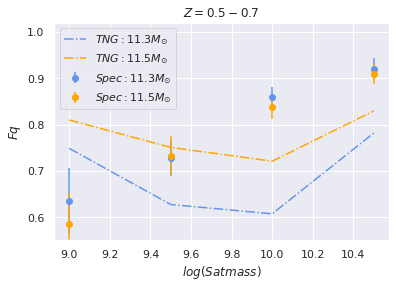

In [58]:
cen_bin = [11.3, 11.5, 11.7]
sate_bin = [9.0, 9.5, 10.0, 10.5,11.0]
color0 = ['cornflowerblue','orange']   #######e','seagreen',
for i in range(2):
    for j in range(4):
       
        if j==0:
            continue
        data = np.load("./result.npy")
        plt.errorbar(sate_bin[j],data[0][i][j],data[1][i][j],color = color0[i],fmt = 'o')

        
plt.errorbar(sate_bin[0],data[0][0][0],data[1][0][0],color = color0[0],fmt = 'o',label = "$Spec : %s M_{\odot}$"%cen_bin[0])
plt.errorbar(sate_bin[0],data[0][1][0],data[1][1][0],color = color0[1],fmt = 'o',label = "$Spec : %s M_{\odot}$"%cen_bin[1])

TNG = np.load("./TNG_fq.npy.npz")
plt.plot(sate_bin[:-1],TNG['version2'][0],color = color0[0],linestyle = '-.',label = "$TNG : 11.3 M_{\odot}$")
plt.plot(sate_bin[:-1],TNG['version2'][1],color = color0[1],linestyle = '-.',label = "$TNG : 11.5 M_{\odot}$")


plt.xlabel("$log(Sat mass)$")
plt.ylabel("$Fq$")
plt.legend(loc = "upper left")
plt.title("$Z = 0.5 - 0.7$")
plt.ylim(0.55,1.02)
# plt.plot()
plt.savefig("/home/yunzheng/PAC/picture/PCF_colorcut/Fq_0.5.pdf",dpi = 100)